In [1]:
%matplotlib notebook 
# Import modules
import os
import math
import numpy as np
import matplotlib.pyplot
import matplotlib.mlab as mlab
import re
#import pandas as pd
from scipy.stats import norm
from pyne import serpent
from pyne import nucname
import time
import multiprocessing as mp
import itertools

/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/pyne/serpent.py:11: QAWarning: pyne.serpent is not yet QA compliant.
  warn(__name__ + " is not yet QA compliant.", QAWarning)


In [2]:
def read_keff(index):
    res_file = dir+prefix+str(index)+'_res.m'
    res = serpent.parse_res(res_file, write_py=False)
    return res['IMP_KEFF'][:,0]

def read_std(index):
    res_file = dir+prefix+str(index)+'_res.m'
    res = serpent.parse_res(res_file, write_py=False)
    return res['IMP_KEFF'][:,1]
    
def read_comp(index):
    dep_file = dir+prefix+str(index)+'_dep.m'
    dep = serpent.parse_dep(dep_file, write_py=False,make_mats=False)
    return dep['MAT_fuel_MDENS']

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

# dir = '../sampler/'
dir = '../sampler_endf/'
prefix = 'tap_'
fnum_start = 0   # first file index
fnum_end = 999   # last file index 999
iso_list = ['U234','U235', 'U236','U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Xe135', 'I135', 'Am241']

ncpu = mp.cpu_count()
# res_d = serpent.parse_res(dir+prefix+str(0)+'_res.m', write_py=False)
dep_d = serpent.parse_dep(dir+prefix+str(0)+'_dep.m', write_py=False,make_mats=False)
days = dep_d['DAYS']
vol_fuel = dep_d['MAT_fuel_VOLUME'][0]
iso_names = dep_d['NAMES'][0].split()
print(vol_fuel)
#print(iso_names)

44353000.0


In [ ]:
start_time = time.time()
with mp.Pool(processes = ncpu) as p:
    k_ds_list = p.map(read_keff, [idx for idx in range(0, fnum_end-fnum_start+1)])
#d = read_comp(0)
#print(vol_fuel*d[iso_names.index('U235'),:])
k_ds_array = np.array(k_ds_list)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [3]:
# np.savetxt('keff_1000_samples.gz', k_ds_array, fmt='%s')
# np.savez_compressed('./keff_1000_samples_endf.npz', b=k_ds_array)
with np.load('./keff_1000_samples_endf.npz', allow_pickle=True) as data:
    k_ds_array = data['b']

In [ ]:
start_time = time.time()
with mp.Pool(processes = ncpu) as p:
    depletion_ds = p.map(read_comp, [idx for idx in range(0, fnum_end-fnum_start+1)])
depletion = np.array(depletion_ds)
#print(vol_fuel*depletion[iso_names.index('U235'),:])
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [4]:
#np.savez_compressed('depleted_mass_1000_samples_endf.npz', a=depletion)
with np.load('depleted_mass_1000_samples_endf.npz', allow_pickle=True) as data:
    depletion = data['a']
print(depletion.shape)

(1000, 1155, 31)


In [18]:
with mp.Pool(processes = ncpu) as p:
    std_k_list = p.map(read_std, [idx for idx in range(0, fnum_end-fnum_start+1)])
std_k_sss_arr = np.array(std_k_list)

In [ ]:
# Checking sizes of array (all keff should be 31 depletion steps size)
for s in range(len(k_ds_array)):
    if len(k_ds_array[s]) != 31:
        print(s, len(k_ds_array[s]))

In [5]:
k_eff = []
std_k = []
std_k_sss = []
rel_err = []
nsamp, nt = k_ds_array.shape

for t in range(nt):
    k_eff.append(np.mean(k_ds_array[:,t]))
    std_k.append(1e+5*np.std(k_ds_array[:,t]))
    rel_err.append(100*np.std(k_ds_array[:,t])/np.mean(k_ds_array[:,t]))
    std_k_sss.append(1e5*np.mean(std_k_sss_arr[:,t]))
    # std_k_sss.append(1e5*std_k_sss_arr[0,t])

print(len(k_eff), nsamp)            
# print(std_k_sss)
print(r"Keff at BOC %5.5f +- %5.1f pcm; Std/mean %5.3f %%" %(k_eff[0],std_k[0], rel_err[0]))
print(r"Keff at EOC %5.5f +- %5.1f pcm; Std/mean %5.3f %%" %(k_eff[-1],std_k[-1], rel_err[-1]))


31 1000
Keff at BOC 1.03481 +-  35.0 pcm; Std/mean 0.034 %
Keff at EOC 0.74524 +-  29.4 pcm; Std/mean 0.039 %


In [15]:
mass = {}
mass_std = {}
mass_rel = {}
nsampl, isos_number, nt = np.shape(depletion)

print(nsampl, isos_number, nt)
for iso in iso_list:
    iso_idx = iso_names.index(iso)
    mass[iso] = []
    mass_std[iso] = []
    mass_rel[iso] = []
    for t in range(nt):
        mass[iso].append(1e-3*vol_fuel*np.mean(depletion[:,iso_idx,t]))
        mass_std[iso].append(1e-3*vol_fuel*np.std(depletion[:,iso_idx,t]))
        mass_rel[iso].append(100* np.std(depletion[:,iso_idx,t])/np.mean(depletion[:,iso_idx,t]))

#print(mass)            
#print(mass_std)
#print(mass_rel)
print("U235 mass at BOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U235'][1],mass_std['U235'][1], mass_rel['U235'][1]) )
print("U235 mass at EOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U235'][-1],mass_std['U235'][-1], mass_rel['U235'][-1]) )
print("\nUranium enrichement at BOC %7.3f %%" %(100*mass['U235'][0]/(mass['U235'][0]+mass['U238'][0])) )
print("\nUranium enrichement at EOC %7.3f %%" %(100*mass['U235'][-1]/(mass['U235'][-1]+mass['U238'][-1])) )
print("\nU238 mass at BOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U238'][1],mass_std['U238'][1], mass_rel['U238'][1]) )
print("U238 mass at EOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U238'][-1],mass_std['U238'][-1], mass_rel['U238'][-1]) )

1000 1155 31
U235 mass at BOC 6282.598 +- 0.049 kg; Std/mean 0.0008 %
U235 mass at EOC 789.914 +- 0.137 kg; Std/mean 0.0173 %

Uranium enrichement at BOC   5.000 %

Uranium enrichement at EOC   0.700 %

U238 mass at BOC 129498.344 +- 0.347 kg; Std/mean 0.0003 %
U238 mass at EOC 112084.784 +- 1.983 kg; Std/mean 0.0018 %


/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [ ]:
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1, figsize=(9, 4))
ax1 = fig_1.add_subplot(121)
#ax1.grid(True)

num_bins = 20

textstr = '\n'.join((
    r'$\mathrm{mean}=%.5f$' % (k_eff[0]),
    r'$\sigma=%.1f$ pcm' % (std_k[0])))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

k_frac = k_ds_array[:,0]/float(len(k_ds_array[:,0]))
n, bins, patches = ax1.hist(k_ds_array[:,0], bins=num_bins, normed=1, facecolor='g',edgecolor='b',alpha=0.75)
y = mlab.normpdf(bins, k_eff[0], 1e-5*std_k[0])
ax1.plot(bins, y, 'b--')


ax1.text(0.03, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax1.set_xlabel(r'$k_{eff}$')
ax1.set_ylabel(r'Probability')
#ax1.set_xlim(1.0335, 1.036)
#fig_1.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/endf_serpent_keff_boc_for_tap',bbox_inches='tight', dpi=700)
#fig_1.show()

ax2 = fig_1.add_subplot(122)
#ax2.grid(True)
n, bins2, patches = ax2.hist(k_ds_array[:,-1], bins=num_bins, normed=1, facecolor='g',edgecolor='b',alpha=0.75)
y2 = mlab.normpdf(bins2, k_eff[-1], 1e-5*std_k[-1])
ax2.plot(bins2, y2, 'b--')

textstr2 = '\n'.join((
    r'$\mathrm{mean}=%.5f$' % (k_eff[-1]),
    r'$\sigma=%.1f$ pcm' % (std_k[-1])))

ax2.text(0.03, 0.95, textstr2, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

#ax.legend(loc=0)
ax2.set_xlabel(r'$k_{eff}$')
ax2.set_ylabel(r'Probability')
#ax2.xaxis.set_ticks(bins2)
ax2.set_xlim(0.744, 0.7465)

#ax.set_title('Full-core TAP (Serpent): Infinite muliplication factor for EOL')
fig_1.subplots_adjust(wspace=-0.5)
fig_1.tight_layout()
fig_1.show()
#fig_1.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/endf_serpent_keff_hist_for_tap.png',bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


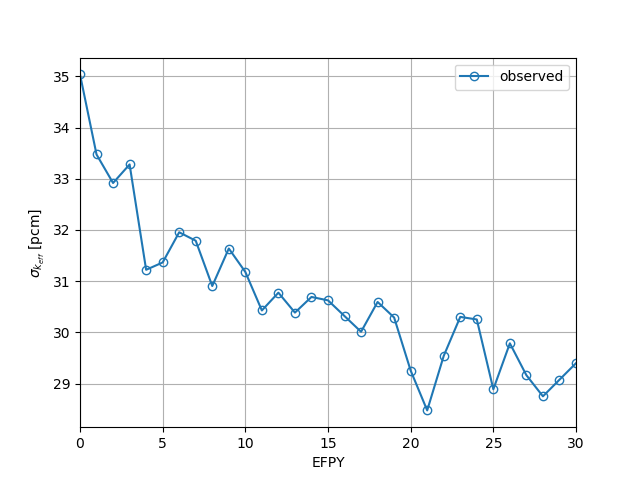

30.701819624569183 nan


/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Initialize figure
fig_keff_std = matplotlib.pyplot.figure(3)
ax = fig_keff_std.add_subplot(111)
ax.grid(True)
ax.plot(days/365.0, std_k, '-o', label='observed', markerfacecolor="None")
#ax.plot(days/365.0, std_k_sss, '-s', label='reported', markerfacecolor="None")

ax.legend(loc=0)
ax.set_ylabel(r'$\sigma_{k_{eff}}$ [pcm]')
ax.set_xlabel('EFPY')
ax.set_xlim(0, 30)
#ax.set_title('Multiplication factor uncertanty')
#fig_keff_std.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/endf_serpent_keff_dynamics_for_tap.png', bbox_inches='tight', dpi=700)
fig_keff_std.show()
print(np.mean(std_k), np.mean(std_k_sss))

<IPython.core.display.Javascript object>


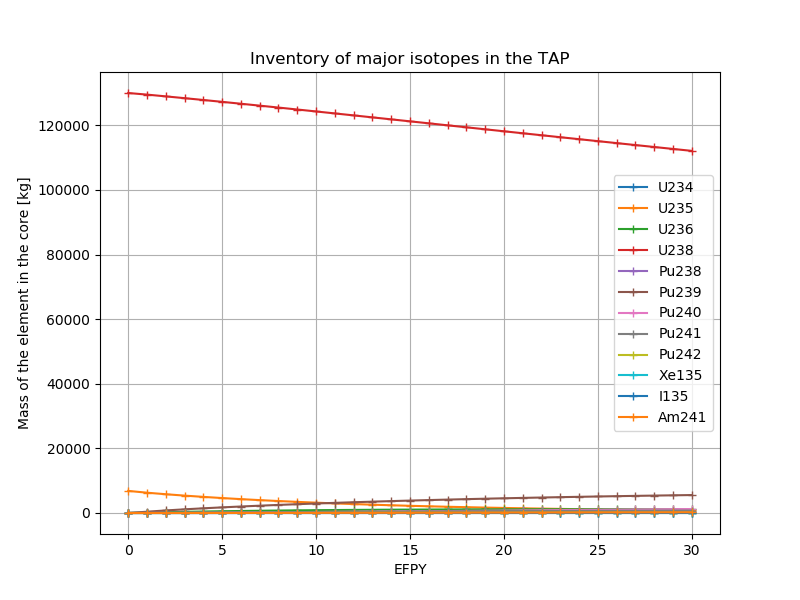

<IPython.core.display.Javascript object>


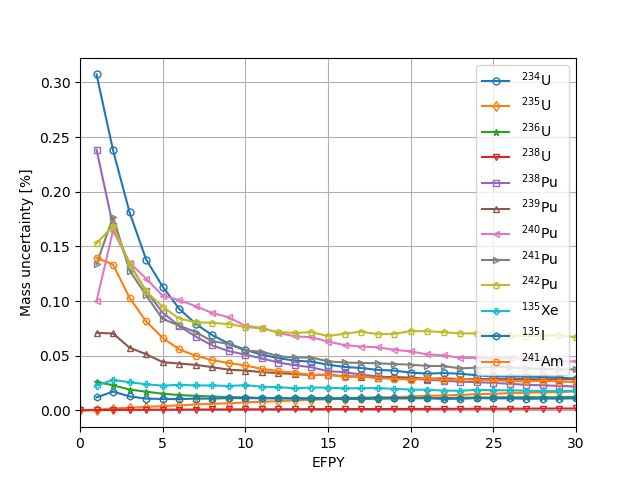

In [7]:
markers=itertools.cycle(('o','d','*','v','s','^','<','>','p','P','h','H','+','x','X','D','|','_'))
# plot_list = ['U235', 'U236','U238'] #, 'Pu239', 'Pu241'] #, 'Xe135', 'I135']
# plot_list = ['Pu239','Pu240', 'Pu241', 'Pu242'] #, 'Pu239', 'Pu241'] #, 'Xe135', 'I135']
# plot_list = ['Xe135', 'I135']
plot_list = iso_list
# Initialize figure
fig_mass = matplotlib.pyplot.figure(4, figsize=[8,6])
ax = fig_mass.add_subplot(111)
ax.grid(True)

for iso in plot_list:
    ax.plot(days/365.0, mass[iso], '+-', label=iso, markerfacecolor="None")

ax.legend(loc=0)
ax.set_ylabel(r'Mass of the element in the core [kg]')
ax.set_xlabel('EFPY')
ax.set_title('Inventory of major isotopes in the TAP')
fig_mass.show()
#fig_mass.savefig('keff_std_pwr_vs_tap.png', bbox_inches='tight', dpi=700)

# Initialize figure
fig_rel_error = matplotlib.pyplot.figure(5)
ax = fig_rel_error.add_subplot(111)
ax.grid(True)

for iso in plot_list:
    m=next(markers)
    el_aaa = elem_aaa(iso)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax.plot(days/365.0, mass_rel[iso], '-s', label=k_name, markersize=5, marker=m, markerfacecolor="None")

ax.legend(loc=0)
ax.set_ylabel(r'Mass uncertainty [%]')
ax.set_xlabel('EFPY')
ax.set_xlim(0, 30)
#ax.set_title('Uncertainty from Serpent in mass of major isotopes in the TAP')
fig_rel_error.show()
#fig_rel_error.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/serpent_mass_std_xe_i.png', bbox_inches='tight', dpi=700)

In [17]:
mom = -1
for iso in iso_list:
    print('At the EOL (kg)', iso, mass[iso][mom], mass_std[iso][mom], mass_rel[iso][mom])

At the EOL (kg) U234 25.800677791419 0.007485712164609977 0.029013626018381724
At the EOL (kg) U235 789.9144490658 0.13653143034410348 0.017284331297594782
At the EOL (kg) U236 1149.5387875617 0.14389536957930363 0.012517661094717976
At the EOL (kg) U238 112084.78386748 1.9834939300194332 0.0017696371100332016
At the EOL (kg) Pu238 405.49885086322996 0.08844193048764319 0.0218106488586508
At the EOL (kg) Pu239 5554.265736861 1.5860258418308641 0.028555094714053212
At the EOL (kg) Pu240 1230.1672857312 0.5509530585478722 0.044786840370282716
At the EOL (kg) Pu241 763.0588761072 0.28587845879797197 0.03746479698347808
At the EOL (kg) Pu242 139.01158685702 0.0930295030984102 0.06692212153084436
At the EOL (kg) Xe135 0.028594691300766997 5.117807987510692e-06 0.017897755683669213
At the EOL (kg) I135 0.018823544130056002 2.0750738145155715e-06 0.011023821019986623
At the EOL (kg) Am241 218.32243368368 0.056570067648962344 0.025911248191253133


In [ ]:
#sample_number_list = np.arange(290, 1010, 10)
sample_number_list = np.arange(0, 1001, 1)
std_samp_conv_k = []
std_samp_conv = []

for num in sample_number_list:
    std_samp_conv_k.append(1e5*np.std(k_ds_array[:num,-1]))
    # mass in kg
    #std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1])/ \
    #                         np.median(depletion[:num,iso_names.index('U235'),-1]))
    std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1]) /\
                         np.median(depletion[:num,iso_names.index('U235'),-1]))

# Initialize figure
fig_std_convergance = matplotlib.pyplot.figure(6)
ax = fig_std_convergance.add_subplot(111)
ax.grid(True)
ax.plot(sample_number_list, std_samp_conv, '-', label='TAP', linewidth=1.0)

#ax.legend(loc=0)
ax.set_ylabel(r'$^{235}$U mass uncertainty [%]')
ax.set_xlabel('# of samples')
ax.set_xlim(0, 1000)
ax.set_title(r'$^{235}$U mass uncertanty convergance')
fig_std_convergance.show()
#fig_std_convergance.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_u235_mass_convergance_for_tap.png', bbox_inches='tight', dpi=700)

# Initialize figure
fig_std_convergance_k = matplotlib.pyplot.figure(7, figsize=[6,4])
ax1 = fig_std_convergance_k.subplots()
ax1.grid(True)
ax1.plot(sample_number_list, std_samp_conv_k, '-', linewidth=1.0, color='b')

ax1.tick_params('y', colors='b')
ax1.set_ylabel(r'$\sigma_{k_{eff}}$ [pcm]', color='b')
ax1.set_xlabel('# of samples')
ax1.set_xlim(0, 1000)

ax2 = ax1.twinx()
#ax2.set_prop_cycle(color=colors[1:])
#ax2.set_ylabel(r'mass difference from $\epsilon_{Xe}=0.915$ [%]')
ax2.set_ylabel(r'$^{235}$U mass uncertainty at the EOL [%]', color='red')
ax2.plot(sample_number_list, std_samp_conv, '-', linewidth=1.0, color='r')
#ax2.legend(loc=1)
#ax2.set_ylim(0, 3.2)
ax2.tick_params('y', colors='r')

fig_std_convergance_k.show()
#fig_std_convergance_k.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq/serpent_convergance_for_tap.png', bbox_inches='tight', dpi=700)